In [ ]:
import torch
import torchaudio.transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import HTML


from sincnet.model import (
    SincNet, Tokenizer,
    compute_forward_mu_law_companding, compute_backward_mu_law_companding, 
    compute_forward_mu_law_quantize, compute_backward_mu_law_quantize
)

from datasets.utils.waveform import WaveformLoader

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
SAMPLE_RATE = 16_000
CHUNK_DURATION = 5
audio_loader = WaveformLoader(sample_rate=SAMPLE_RATE, chunk_duration=CHUNK_DURATION)

Initialising waveform loader with sample rate sr:16000...


In [4]:
model = SincNet(scale="lin").load_pretrained_weights().eval().to(device)

Loading SincNet:16000_128_127_real_lin_causal...
Specified weights_path is None.
Attempting to load from /home/techwills/techwills/sonustech/sincnet/pretrained/16000_128_127_real_lin_causal.ckpt...


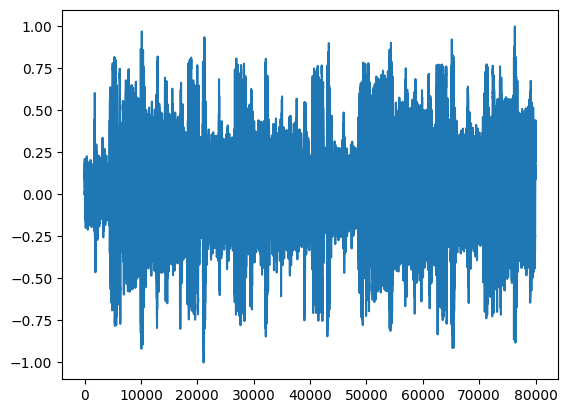

In [5]:
audio_pathes = {
    0:"audio/ashcraft-divae-matris.wav",
    #1:"audio/astronautica-reasons.m4a",
    2:"audio/ashcraft-pathes-of-words.mp3",
    3:"audio/Hypersense.mp3",
    4:"audio/jordan-f-feel-my-love-feat-quails-our-destiny-above-us.mp3",
    5:"audio/Sessionbuilder-preview.mp3",
    6:"audio/space-of-soul.mp3",
    7:"audio/stellardrone-billions-and-billions-spaceambient.mp3",
    8:"audio/kyara-world-edge.mp3",
    9:"audio/tonight.mp3",
    10:"audio/15033000.mp3",
    11:"audio/16366200.mp3",
    12:"audio/16129994.mp3",
    13:"audio/16176213.mp3",
    14:"audio/mecha-maiko-cold-feat-dana-jean-phoenix.mp3",
    15:"audio/miami-nights-1984-accelerated.mp3",
    16:"audio/nina-empire-of-love.mp3",
    17:"audio/nina-sleepwalking.mp3",
    18:"audio/samplerules/drum-n-bass/15827805.mp3",
    19:"audio/samplerules/drum-n-bass/15890486.mp3",
    20:"audio/samplerules/drum-n-bass/16181815.mp3",
    21:"audio/samplerules/drum-n-bass/16193249.mp3",
    22:"audio/samplerules/drum-n-bass/16252608.mp3"
}

audio_path = audio_pathes[22]
waveform = audio_loader.load(audio_path, offset=75, duration=5)

plt.plot(waveform[0])
ipd.Audio(waveform, rate=SAMPLE_RATE, autoplay=False)

In [6]:
q_bits = 8
tokenizer = Tokenizer(q_bits=q_bits, use_mulaw_companding=True)

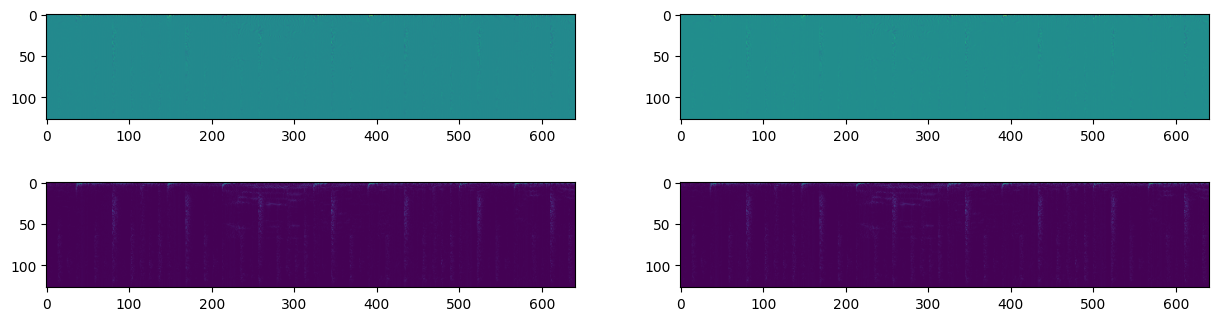

In [7]:
with torch.no_grad():
    # trnsform the waveform into tensor
    wav = torch.from_numpy(waveform).to(device).float()

    #encode and decode waveform
    s = model.encode(wav.unsqueeze(0))
    #s = s[:,:2]
    reconstructed_wav = model.decode(s)

    #apply tokenizer
    sq = tokenizer(s)
    sr = tokenizer.inverse(sq)
    detokenized_wav = model.decode(sr)

    #apply mu-law-companding for visualization
    #s = compute_forward_mu_law_companding(s, q_bits=q_bits)
    #sr = compute_forward_mu_law_companding(sr, q_bits=q_bits)


f, axes = plt.subplots(2, 2, figsize=(15, 4))
y = s[0].detach().numpy()
yr = sr[0].detach().numpy()

axes[0,0].imshow(y)
axes[1,0].imshow(np.abs(y))

axes[0,1].imshow(yr)
axes[1,1].imshow(np.abs(yr))

# Create your Audio objects
audio1 = ipd.Audio(reconstructed_wav, rate=SAMPLE_RATE, autoplay=False)
audio2 = ipd.Audio(detokenized_wav, rate=SAMPLE_RATE, autoplay=False)
# Embed them in HTML with flexbox for horizontal layout
html_content = f"""
<div style="display:flex; justify-content:space-around;">
    <div>
        <h3>Reconstructed waveform</h3>
        {audio1._repr_html_()}
    </div>
    <div>
        <h3>Detokenized waveform</h3>
        {audio2._repr_html_()}
    </div>
</div>
"""
# Display the HTML
display(HTML(html_content))